In [1]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

C:\Users\tnemeth\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Input Source Image filename:

In [2]:
all_cog_data_filename = "H001/H001_OS_cog_data.csv"

Input labels (as tif) filename:

In [3]:
labels_data_filename = "H001/H001_OS_bundles.tif"

Output Filenames:

In [4]:
pore_diameter_output_file_prefix = "H001_OS_pore_diameter_data"

---

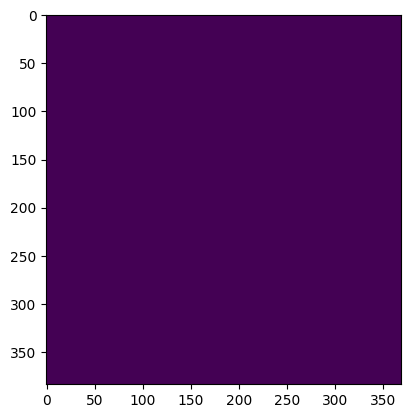

In [5]:
labels_data = skio.imread(labels_data_filename, plugin="tifffile")
plt.imshow(labels_data[200,:,:])

In [7]:
# Data Organization
# [group_number, slice_x, cog_y, cog_z]
all_cog_data = np.loadtxt(all_cog_data_filename, delimiter=",")

In [8]:
# Data organization
# [Bundle number, slice x, pore diameter]
pore_diameter_data = []

In [9]:
# Loop over each bundle
bundles = np.unique(all_cog_data[:,0])
for bundle_number in bundles:
    
    # Get data for only this bundle
    this_bundle_data = all_cog_data[np.where(all_cog_data[:,0] == bundle_number)]
    
    # Start from bottom, work to top of axon bundle
    for i in range(0, len(this_bundle_data) - 1):
        
        # Reset pore diameter
        pore_diameter = 0
        
        # Get slice x
        slice_x = int(this_bundle_data[i,1])
        #print(slice_x)
        
        # Find b and c (vector coefficients)
        b_coef = this_bundle_data[i+1, 2] - this_bundle_data[i,2]
        c_coef = this_bundle_data[i+1, 3] - this_bundle_data[i,3]
        #print(b_coef)
        #print(c_coef)
        
        # Calculate d where by + cz + d = 0
        d_coef = (b_coef * this_bundle_data[i,2]) + (c_coef * this_bundle_data[i,3])
        #print(d_coef)
        #print("=====")
        
        # Find coordinates of each label pixels for this bundle on this slice
        label_pixels = []
        for yi in range(0, labels_data.shape[1]):
            for zi in range(0, labels_data.shape[2]):
                if labels_data[slice_x, yi, zi] == bundle_number:
                    label_pixels.append([yi,zi])
                    #print([yi,zi])
        
        # Now check each pixel to see if they fall on the line intersecting the perpendicular plane
        for pix_index in range(0, len(label_pixels)):
            if abs((b_coef * label_pixels[pix_index][0]) + (c_coef * label_pixels[pix_index][1]) - d_coef) <= 0.5:
                pore_diameter = pore_diameter + 1

        # Add to data array
        pore_diameter_data.append([bundle_number, slice_x, pore_diameter])

In [10]:
np.savetxt((pore_diameter_output_file_prefix + ".csv"), pore_diameter_data, delimiter=",")

---

## Pore Diameter Data Analysis

In [6]:
pore_diameter_filename = "H005_pore_diameter_data.csv"

In [7]:
# Load in data
# [Bundle number, slice x, pore diameter]
pore_diameter_data = np.loadtxt(pore_diameter_filename, delimiter=",")

In [30]:
np.median(pore_diameter_data[:,2])

35.0

### Distribution of Pore Diameters 0-100

(array([201., 320., 246., 204., 178., 122.,  70.,  72.,  54.,  47.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

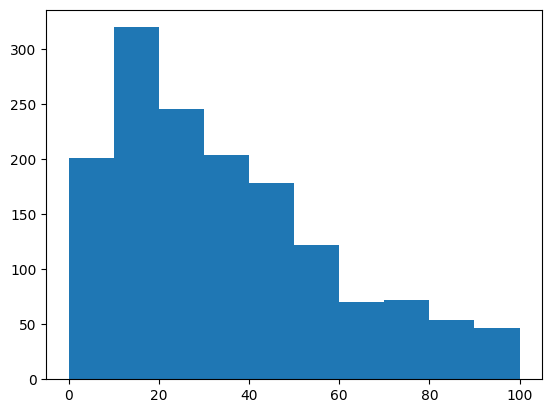

In [17]:
fig, ax = plt.subplots()
ax.hist(pore_diameter_data[:,2], range=[0,100])

### Distribution of all Pore Diameters

(array([1.726e+03, 1.600e+01, 4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   0. ,  391.5,  783. , 1174.5, 1566. , 1957.5, 2349. , 2740.5,
        3132. , 3523.5, 3915. ]),
 <BarContainer object of 10 artists>)

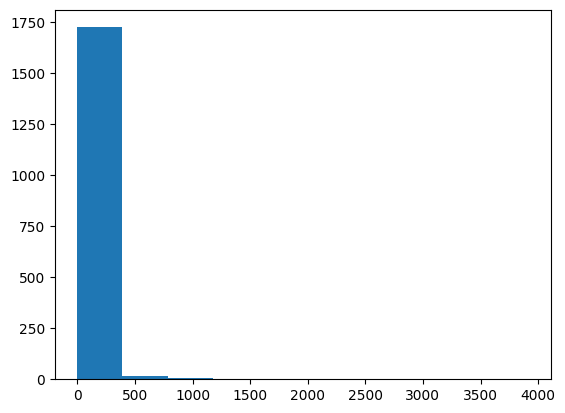

In [18]:
fig, ax = plt.subplots()
ax.hist(pore_diameter_data[:,2])

### Comparing PD to depth

(array([[ 3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  7.,  7.,  2.,  4.,  0.,  0.,  0.,  1.,  0.],
        [13., 21.,  7., 11., 10.,  2.,  2.,  5.,  0.,  1.],
        [66., 83., 54., 33., 28., 12., 10.,  5.,  3.,  6.],
        [49., 71., 55., 37., 29., 22.,  9.,  8.,  9.,  4.],
        [17., 51., 44., 49., 43., 32., 15., 18., 11.,  9.],
        [22., 34., 31., 34., 30., 30., 15., 14., 17.,  7.],
        [18., 30., 26., 28., 23., 14., 10., 14.,  6., 10.],
        [10., 17., 18., 10.,  9., 10.,  9.,  5.,  7., 10.],
        [ 0.,  4.,  4.,  0.,  2.,  0.,  0.,  3.,  0.,  0.]]),
 array([175., 200., 225., 250., 275., 300., 325., 350., 375., 400., 425.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <matplotlib.collections.QuadMesh at 0x22cc18bff40>)

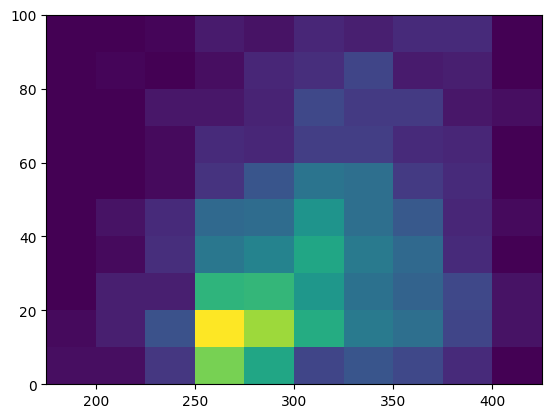

In [28]:
fig, ax = plt.subplots()
ax.hist2d(pore_diameter_data[:,1], pore_diameter_data[:,2], range=[[175,425],[0,100]])

Explanation: This 2D histogram plots the depth (Z Slice) on the x axis vs length of the pore diameter on the y axis. Color intensity represents the frequency of values - i.e. The most 